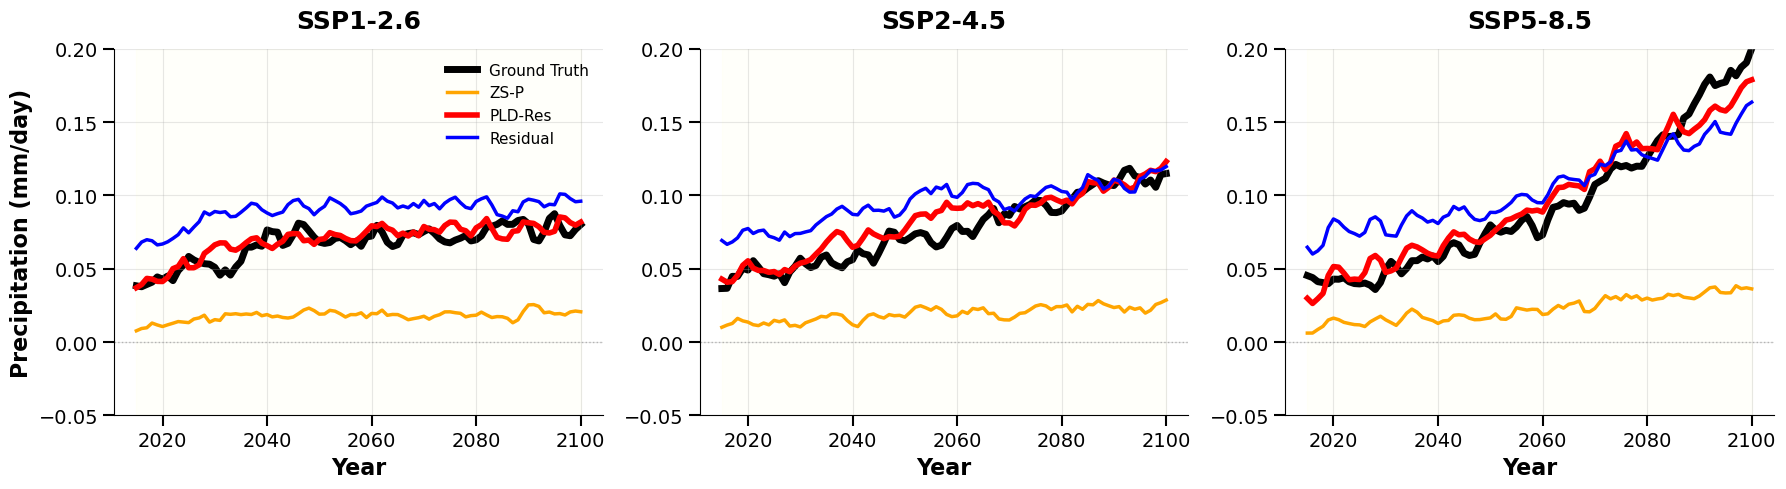

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Load original datasets for baseline calculation
data_dir = Path("../data")
ds_hist_orig = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")

# Define time periods for shading
time_periods = [
    (2015, 2100, 'lightyellow', 0.15)  # SSP period only
]

# Scenarios (SSP only)
scenarios = ['ssp126', 'ssp245', 'ssp585']
scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Variable
var = 'pr'
var_label = 'Precipitation (mm/day)'

# Model names and colors
models = ['zscore_pixel', 'pld_residual', 'raw_residual']
model_labels = {
    'zscore_pixel': 'ZS-P',
    'raw_residual': 'Residual',
    'pld_residual': 'PLD-Res'
}
model_colors = {
    'zscore_pixel': 'orange',
    'raw_residual': 'blue',
    'pld_residual': 'red'
}

# Y-axis configuration
ylim = (-0.05, 0.20)
ytick = 0.05

def calc_baseline(ds, var, start_year=1850, end_year=1900):
    """Calculate baseline mean for reference period"""
    data = ds[var]
    years = ds.time.dt.year
    mask = (years >= start_year) & (years <= end_year)
    baseline_data = data.isel(time=mask)
    baseline = baseline_data.mean(dim=['time', 'lat', 'lon'])
    return float(baseline.values)

def calc_global_mean(data):
    """Calculate simple global mean"""
    return np.mean(data, axis=(1, 2))

def to_annual_mean(data, time_coords):
    """Convert to annual averages"""
    years = time_coords.dt.year.values
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean to annual data"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Calculate baseline
var_hr = f"{var}_hr"
baseline_mean = calc_baseline(ds_hist_orig, var_hr, 1850, 1900)

# Create 1x3 figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for col, scenario in enumerate(scenarios):
    ax = axes[col]
    time_slice = slice('2015', '2100')
    
    # Load ground truth
    gt_file = results_dir / f"{var}_evaluation_{scenario}.nc"
    
    if gt_file.exists():
        ds_gt = xr.open_dataset(gt_file)
        gt_data = ds_gt['groundtruth'].sel(time=time_slice).values
        time_coords = ds_gt['groundtruth'].sel(time=time_slice).time
        
        # Calculate ground truth statistics
        gt_mean = calc_global_mean(gt_data) - baseline_mean
        years_gt, gt_mean_annual = to_annual_mean(gt_mean, time_coords)
        gt_mean_smooth = smooth_data(gt_mean_annual)
        
        # 1. Plot ground truth FIRST (bottom layer)
        ax.plot(years_gt, gt_mean_smooth, color='black', 
               linewidth=5, label='Ground Truth', zorder=1)
        
        # 2. Load and plot ZS-P - solid line
        pred_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        if pred_file.exists():
            ds_pred = xr.open_dataset(pred_file)
            if 'pred_zscore_pixel' in ds_pred:
                pred_data = ds_pred['pred_zscore_pixel'].sel(time=time_slice).values
                pred_mean = calc_global_mean(pred_data) - baseline_mean
                years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                pred_mean_smooth = smooth_data(pred_mean_annual)
                
                ax.plot(years_pred, pred_mean_smooth, 
                       color=model_colors['zscore_pixel'], linestyle='-',
                       linewidth=2.5, label=model_labels['zscore_pixel'], alpha=1.0, zorder=2)
        
        # 3. Load and plot PLD-Res - solid line
        pred_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
        if pred_file.exists():
            ds_pred = xr.open_dataset(pred_file)
            if 'pred_grid' in ds_pred:
                pred_data = ds_pred['pred_grid'].sel(time=time_slice).values
                pred_mean = calc_global_mean(pred_data) - baseline_mean
                years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                pred_mean_smooth = smooth_data(pred_mean_annual)
                
                ax.plot(years_pred, pred_mean_smooth, 
                       color=model_colors['pld_residual'], linestyle='-',
                       linewidth=4, label=model_labels['pld_residual'], alpha=1.0, zorder=3)
            
            # 4. Plot Residual - dashed line
            if 'pred_raw' in ds_pred:
                pred_data = ds_pred['pred_raw'].sel(time=time_slice).values
                pred_mean = calc_global_mean(pred_data) - baseline_mean
                years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                pred_mean_smooth = smooth_data(pred_mean_annual)
                
                ax.plot(years_pred, pred_mean_smooth, 
                       color=model_colors['raw_residual'], linestyle='-',
                       linewidth=2.5, label=model_labels['raw_residual'], alpha=1.0, zorder=4)
    
    # Format axes
    for start_year, end_year, color_shade, alpha in time_periods:
        ax.axvspan(start_year, end_year, color=color_shade, alpha=alpha, zorder=0)
    
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Set y-axis
    ax.set_ylim(ylim)
    ax.set_yticks(np.arange(ylim[0], ylim[1] + ytick/2, ytick))
    
    # Labels
    ax.set_title(scenario_labels[scenario], fontsize=18, fontweight='bold', pad=15)
    
    if col == 0:
        ax.set_ylabel(var_label, fontsize=16, fontweight='bold')
    
    ax.set_xlabel('Year', fontsize=16, fontweight='bold')
    
    # Legend (only on first panel)
    if col == 0:
        ax.legend(loc='best', fontsize=11, frameon=False)
    
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Increase tick parameters
    ax.tick_params(labelsize=14, length=8, width=1.5)

plt.tight_layout()

output_file = figures_dir / "pr_temporal_evolution.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

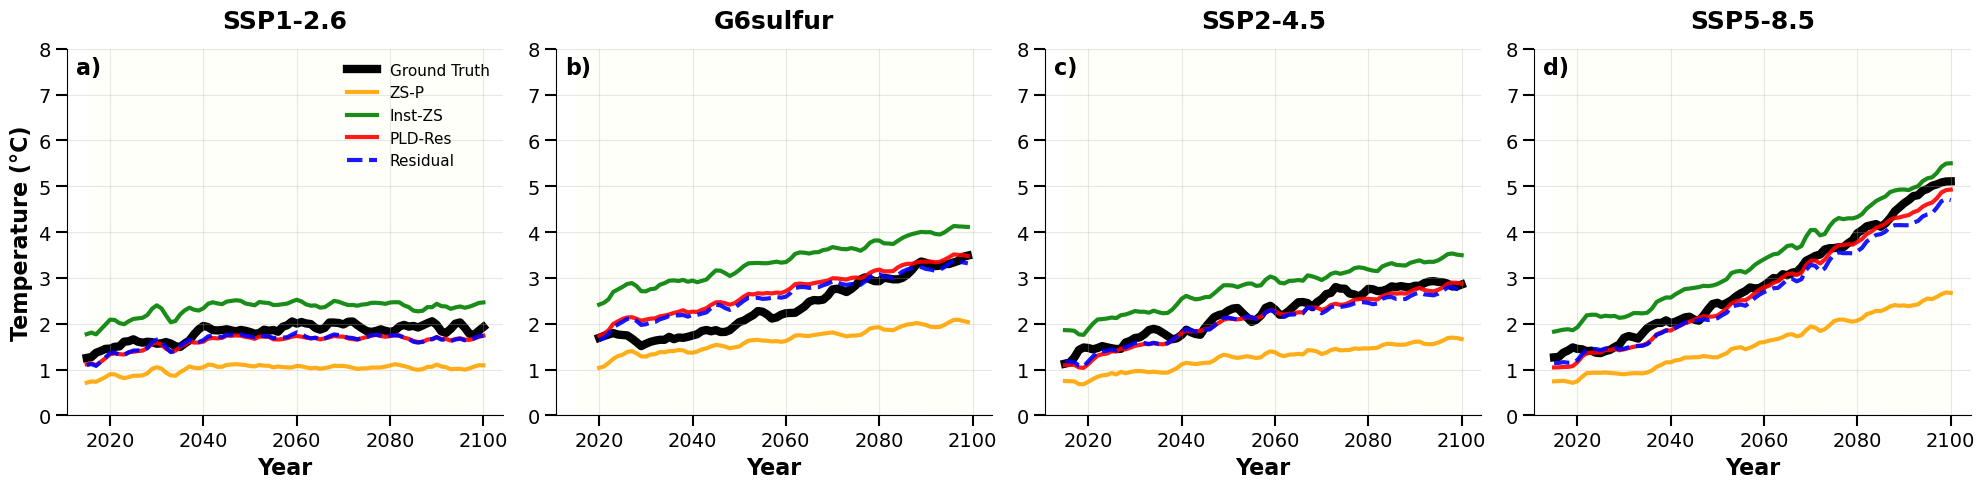

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Load original datasets for baseline calculation
data_dir = Path("../data")
ds_hist_orig = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")

# Define time periods for shading
time_periods = [
    (2015, 2100, 'lightyellow', 0.15)  # SSP period
]

# Scenarios (add g6sulfur after ssp126)
scenarios = ['ssp126', 'g6sulfur', 'ssp245', 'ssp585']
scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'g6sulfur': 'G6sulfur',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Variable
var = 'tas'
var_label = 'Temperature (°C)'

# Model names and colors
models = ['groundtruth', 'zscore_pixel', 'instance_zscore', 'raw_residual', 'pld_residual']
model_labels = {
    'groundtruth': 'Ground Truth',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS',
    'raw_residual': 'Residual',
    'pld_residual': 'PLD-Res'
}
model_colors = {
    'groundtruth': 'black',
    'zscore_pixel': 'orange',
    'instance_zscore': 'green',
    'raw_residual': 'blue',
    'pld_residual': 'red'
}

# Y-axis configuration
ylim = (0, 8)
ytick = 1

def calc_baseline(ds, var, start_year=1850, end_year=1900):
    """Calculate baseline mean for reference period"""
    var_hr = f"{var}_hr"
    data = ds[var_hr]
    years = ds.time.dt.year
    mask = (years >= start_year) & (years <= end_year)
    baseline_data = data.isel(time=mask)
    baseline = baseline_data.mean(dim=['time', 'lat', 'lon'])
    return float(baseline.values)

def calc_global_mean(data):
    """Calculate simple global mean"""
    return np.mean(data, axis=(1, 2))

def to_annual_mean(data, time_coords):
    """Convert to annual averages"""
    years = time_coords.dt.year.values
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean to annual data"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Calculate baseline
baseline_mean = calc_baseline(ds_hist_orig, var, 1850, 1900)

# Create 1x4 figure
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Panel labels
panel_labels = ['a)', 'b)', 'c)', 'd)']

for col, scenario in enumerate(scenarios):
    ax = axes[col]
    
    # Determine time slice based on scenario
    if scenario == 'g6sulfur':
        time_slice = slice('2020', '2099')
    else:
        time_slice = slice('2015', '2100')
    
    # Load ground truth from residual results
    residual_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
    
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        gt_data = ds_residual['groundtruth'].sel(time=time_slice).values
        time_coords = ds_residual['groundtruth'].sel(time=time_slice).time
        
        # Calculate ground truth statistics
        gt_mean = calc_global_mean(gt_data) - baseline_mean
        years_gt, gt_mean_annual = to_annual_mean(gt_mean, time_coords)
        gt_mean_smooth = smooth_data(gt_mean_annual)
        
        # 1. Plot ground truth first (bottom layer) - thick solid line
        ax.plot(years_gt, gt_mean_smooth, 
               color=model_colors['groundtruth'],
               linestyle='-',
               linewidth=6,
               label=model_labels['groundtruth'], zorder=1)
        
        # 2. Load and plot normalization predictions - solid lines
        norm_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        if norm_file.exists():
            ds_norm = xr.open_dataset(norm_file)
            
            for model in ['zscore_pixel', 'instance_zscore']:
                pred_key = f'pred_{model}'
                if pred_key in ds_norm:
                    pred_data = ds_norm[pred_key].sel(time=time_slice).values
                    pred_mean = calc_global_mean(pred_data) - baseline_mean
                    years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                    pred_mean_smooth = smooth_data(pred_mean_annual)
                    
                    ax.plot(years_pred, pred_mean_smooth, 
                           color=model_colors[model],
                           linestyle='-',
                           linewidth=3,
                           label=model_labels[model], alpha=0.9, zorder=2)
        
        # 3. Plot PLD-Res - solid line
        if 'pred_grid' in ds_residual:
            pred_data = ds_residual['pred_grid'].sel(time=time_slice).values
            pred_mean = calc_global_mean(pred_data) - baseline_mean
            years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
            pred_mean_smooth = smooth_data(pred_mean_annual)
            
            ax.plot(years_pred, pred_mean_smooth, 
                   color=model_colors['pld_residual'],
                   linestyle='-',
                   linewidth=3,
                   label=model_labels['pld_residual'], alpha=0.9, zorder=3)
        
        # 4. Plot Residual last - dashed line
        if 'pred_raw' in ds_residual:
            pred_data = ds_residual['pred_raw'].sel(time=time_slice).values
            pred_mean = calc_global_mean(pred_data) - baseline_mean
            years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
            pred_mean_smooth = smooth_data(pred_mean_annual)
            
            ax.plot(years_pred, pred_mean_smooth, 
                   color=model_colors['raw_residual'],
                   linestyle='--',
                   linewidth=3,
                   label=model_labels['raw_residual'], alpha=0.9, zorder=4)
    
    # Format axes
    for start_year, end_year, color_shade, alpha in time_periods:
        ax.axvspan(start_year, end_year, color=color_shade, alpha=alpha, zorder=0)
    
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Set y-axis
    ax.set_ylim(ylim)
    ax.set_yticks(np.arange(ylim[0], ylim[1] + ytick/2, ytick))
    
    # Add panel label
    ax.text(0.02, 0.98, panel_labels[col],
           transform=ax.transAxes,
           fontsize=16, fontweight='bold',
           va='top', ha='left')
    
    # Labels
    ax.set_title(scenario_labels[scenario], fontsize=18, fontweight='bold', pad=15)
    
    if col == 0:
        ax.set_ylabel(var_label, fontsize=16, fontweight='bold')
    
    ax.set_xlabel('Year', fontsize=16, fontweight='bold')
    
    # Legend (only on first panel)
    if col == 0:
        ax.legend(loc='best', fontsize=11, frameon=False)
    
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Increase tick parameters
    ax.tick_params(labelsize=14, length=8, width=1.5)

plt.tight_layout()

output_file = figures_dir / "gmst_temporal_evolution.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

plt.show()